# Bayesian tri-training for semi-supervised domain adaptation

A tri-training bootstrapped approach to domain adaptation for MNIST to USPS using a Bayesian CNN.

Author: @ysbecca, see my [personal blog](ybecca.github.io) for contact.

Credits go to:

- Kuniaki Saito, Yoshitaka Ushiku, Tatsuya Harada, for their work in "Asymmetric Tri-training for Unsupervised Domain Adaptation" which is used as a base for this approach.
- [Hvass-Labs](http://www.hvass-labs.org/) for the base CNN model for MNIST classification. The basics of their CNN was customised and added to for this work.
- [Leo Pauly](https://github.com/leopauly) for the research interest in general.
- Kyle Dorman, Yarin Gal, Alex Kendall for their work in Bayesian deep learning (specific papers referenced below)

In [1]:
import tensorflow as tf
import numpy as np
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
from datetime import timedelta
from importlib import reload
import math
import time

# Custom scripts.
import ysb
import dataset
import mnist_usps as mnus
import cnn_helper as cn

In [2]:
reload(mnus)
reload(dataset)
reload(cn)
reload(ysb)

<module 'ysb' from '/home/ufaserv1_k/sc16rsmy/Domain-Adaptation/MNIST_USPS_Dataset/ysb.py'>

Set parameters.

In [3]:
# Shared net parameters
filter_size1 = 5          # Convolution filters are 5 x 5 pixels.
num_filters1 = 32         # There are 16 of these filters.

filter_size2 = 5         
num_filters2 = 48    

# Individual net parameters (for now we assume both fully connected layers have the same number of units)
fc_size = 100

# IMAGE PARAMETERS
img_size = 16             # Width and height in pixels.

# Images are stored in one-dimensional arrays of this length.
img_size_flat = img_size * img_size

# Tuple with height and width of images used to reshape arrays.
img_shape = (img_size, img_size)

# Number of colour channels for the images: 1 channel for gray-scale.
num_channels = 1

# Number of classes, one class for each of 10 digits.
num_classes = 10

## Load both datasets.

In [4]:
mnist_data, usps_data = dataset.read_datasets()

In [5]:
print("MNIST dataset:")
print("- Training-set:\t\t{}".format(mnist_data.train.num_images))
print("- Test-set:\t\t{}".format(mnist_data.test.num_images))
print("- Validation-set:\t{}".format(mnist_data.valid.num_images))

print("USPS dataset:")
print("- Training-set:\t\t{}".format(usps_data.train.num_images))
print("- Test-set:\t\t{}".format(usps_data.test.num_images))

MNIST dataset:
- Training-set:		49000
- Test-set:		14000
- Validation-set:	7000
USPS dataset:
- Training-set:		7439
- Test-set:		1859


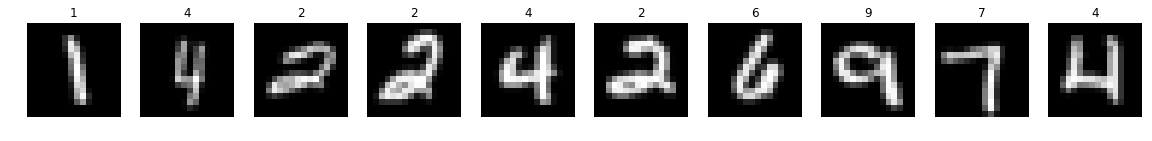

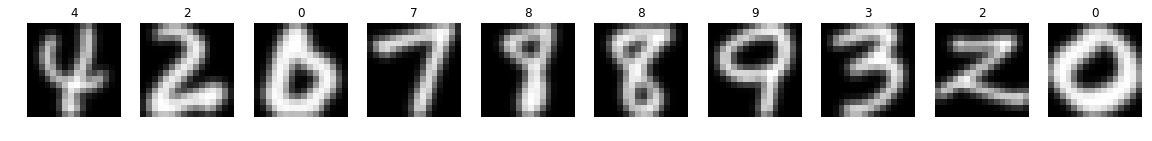

In [6]:
i = 0
to_show = 10
ysb.show_labeled_patches_gray(mnist_data.train.images[i:(i+to_show)], mnist_data.train.cls[i:(i+to_show)])
ysb.show_labeled_patches_gray(usps_data.train.images[i:(i+to_show)], usps_data.train.cls[i:(i+to_show)])

## Build the four networks

The first network, the shared network, will feed into the three tri-training networks: two labeling networks and one target-specific network.

In [9]:
x = tf.placeholder(tf.float32, shape=[None, img_size_flat], name='x')
x_image = tf.reshape(x, [-1, img_size, img_size, num_channels])

y_true = tf.placeholder(tf.float32, shape=[None, num_classes], name='y_true')
y_true_cls = tf.argmax(y_true, dimension=1)

keep_prob = tf.placeholder(tf.float32) # So we can control dropout.
keep_prob_target = tf.placeholder(tf.float32) # Separate dropout rate for the target-only network.

Build TensorFlow graph for the shared network.

In [10]:
shared_net = \
    cn.new_conv_layer(input=x_image,
                   num_input_channels=num_channels,
                   filter_size=filter_size1,
                   num_filters=num_filters1,
                   use_pooling=True)
shared_net = \
    cn.new_conv_layer(input=shared_net,
                   num_input_channels=num_filters1,
                   filter_size=filter_size2,
                   num_filters=num_filters2,
                   use_pooling=True)
shared_net, features = cn.flatten_layer(shared_net)

Now we build the three independent networks, which are identical.

In [11]:
# Labeling network F1
f1_net, _ = cn.new_fc_layer(input=shared_net,       
                         num_inputs=features,
                         num_outputs=fc_size,
                         use_relu=True)
f1_net, f1_w_out = cn.new_fc_layer(input=f1_net,       
                         num_inputs=fc_size,
                         num_outputs=fc_size,
                         use_relu=True)
f1_net = tf.nn.dropout(f1_net, keep_prob=keep_prob)
f1_net, _ = cn.new_fc_layer(input=f1_net,             # This is the classification layer.
                         num_inputs=fc_size,
                         num_outputs=num_classes,            # num_classes = 10
                         use_relu=False)
f1_y_pred = tf.nn.softmax(f1_net)                    
f1_y_pred_cls = tf.argmax(f1_y_pred, dimension=1)


# Labeling network F2
f2_net, _ = cn.new_fc_layer(input=shared_net,
                         num_inputs=features,
                         num_outputs=fc_size,
                         use_relu=True)
f2_net, f2_w_out = cn.new_fc_layer(input=f2_net,          
                         num_inputs=fc_size,
                         num_outputs=fc_size,
                         use_relu=True)
f2_net = tf.nn.dropout(f2_net, keep_prob=keep_prob)
f2_net, _ = cn.new_fc_layer(input=f2_net,          
                         num_inputs=fc_size,
                         num_outputs=num_classes,
                         use_relu=True)
f2_y_pred = tf.nn.softmax(f2_net)                    
f2_y_pred_cls = tf.argmax(f2_y_pred, dimension=1)

# # Labeling network F3
f3_net, _ = cn.new_fc_layer(input=shared_net,
                         num_inputs=features,
                         num_outputs=fc_size,
                         use_relu=True)
f3_net, _ = cn.new_fc_layer(input=f3_net,          
                         num_inputs=fc_size,
                         num_outputs=fc_size,
                         use_relu=True)
f3_net = tf.nn.dropout(f3_net, keep_prob=keep_prob)
f3_net, _ = cn.new_fc_layer(input=f3_net,          
                         num_inputs=fc_size,
                         num_outputs=num_classes,
                         use_relu=True)
f3_y_pred = tf.nn.softmax(f3_net)                    
f3_y_pred_cls = tf.argmax(f3_y_pred, dimension=1)

Now we define the cost for each network.

In [12]:
# Cost for the three networks
f1_cost = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(logits=f1_net, labels=y_true))
f2_cost = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(logits=f2_net, labels=y_true))
f3_cost = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(logits=f3_net, labels=y_true))

# Overall tri-network costs, with a constraint for the weights of F1, F2 to force their inputs to be diffferent.
weight_constraint = tf.reduce_sum( \
                        tf.abs( \
                        tf.multiply( \
                        tf.transpose(f1_w_out), f2_w_out)))
cost = f1_cost + f2_cost + f3_cost + weight_constraint
labeling_cost = f1_cost + f2_cost + weight_constraint
target_only_cost = f3_cost

# Optimisation functions
optimizer_all = tf.train.AdamOptimizer(learning_rate=1e-4).minimize(cost)
optimizer_f1f2 = tf.train.AdamOptimizer(learning_rate=1e-4).minimize(labeling_cost)
optimizer_f3 = tf.train.AdamOptimizer(learning_rate=1e-4).minimize(target_only_cost)

# Individual network accuracies
f1_accuracy = tf.reduce_mean(tf.cast(tf.equal(f1_y_pred_cls, y_true_cls), tf.float32))
f2_accuracy = tf.reduce_mean(tf.cast(tf.equal(f2_y_pred_cls, y_true_cls), tf.float32))
f3_accuracy = tf.reduce_mean(tf.cast(tf.equal(f3_y_pred_cls, y_true_cls), tf.float32))

Now we create a new TensorFlow session and initialise the variables.

In [30]:
tf.set_random_seed(1)
np.random.seed(0)

session = tf.Session()
session.run(tf.global_variables_initializer())
train_batch_size = 128
test_batch_size = 64

saver = tf.train.Saver()

Helper functions for running optimisation iterations and showing test accuracy.

In [31]:
# Counter for total number of iterations performed so far.
total_iterations = 0

def optimize(dataset_train, num_iterations, silent=False, dropout_keep_prob=1.0, optimizers=[]):
    global total_iterations
    start_time = time.time()
    for i in range(total_iterations,
                   total_iterations + num_iterations):
        x_batch, y_true_batch = dataset_train.next_batch(train_batch_size)
        x_batch = x_batch.reshape(len(x_batch), img_size_flat)
        feed_dict_train = {x: x_batch, y_true: y_true_batch, keep_prob: dropout_keep_prob}

        # [optimizer_all, optimizer_f1f2, optimizer_f3]
        session.run(optimizers, feed_dict=feed_dict_train)

        # Print status every 250 iterations.
        if i % 250 == 0:
            # Calculate the accuracy on the training-set.
            acc_f1, acc_f2, acc_f3 = session.run([f1_accuracy, f2_accuracy, f3_accuracy], feed_dict=feed_dict_train)

            if not silent:
                msg = "Optimization Iteration: {0:>6}, Accuracy F1 {1:.1%}, F2 {2:.1%}, F3 {3:.1%}"
                print(msg.format(i+1, acc_f1, acc_f2, acc_f3))

    total_iterations += num_iterations

    end_time = time.time()
    time_dif = end_time - start_time
    if not silent:
        print("Time usage: " + str(timedelta(seconds=int(round(time_dif)))))
    
def print_test_accuracy(dataset_test, show_confusion_matrix=False, quieter=True, silent=True):
    num_test = len(dataset_test.images)
    cls_pred_f1 = np.zeros(shape=num_test, dtype=np.int)
    cls_pred_f2 = np.zeros(shape=num_test, dtype=np.int)
    cls_pred_f3 = np.zeros(shape=num_test, dtype=np.int)
    
    i = 0

    while i < num_test:
        j = min(i + test_batch_size, num_test)
        curr_batch_size = j - i
        
        # Get the images and targets from the test-set between index i and j.
        images = dataset_test.images[i:j, :].reshape(curr_batch_size, img_size_flat)
        labels = dataset_test.labels[i:j, :]
        feed_dict = {x: images, y_true: labels, keep_prob: 1.0}

        cls_pred_f1[i:j], cls_pred_f2[i:j], cls_pred_f3[i:j] = \
                        session.run([f1_y_pred_cls, f2_y_pred_cls, f3_y_pred_cls], feed_dict=feed_dict)
        i = j

    cls_true = dataset_test.cls

    # Create a boolean array whether each image is correctly classified.
    correct_f1, correct_f2, correct_f3 = \
            (cls_true == cls_pred_f1), (cls_true == cls_pred_f2), (cls_true == cls_pred_f3)
    
    correct_sum_f1, correct_sum_f2, correct_sum_f3 = correct_f1.sum(), correct_f2.sum(), correct_f3.sum()
    acc_f1, acc_f2, acc_f3 = \
        float(correct_sum_f1) / num_test, float(correct_sum_f2) / num_test, float(correct_sum_f3) / num_test

    msg = "Accuracy on test set: F1 {0:.1%}, F2 {1:.1%}, F3 {2:.1%}"
    if not quieter:
        print(msg.format(acc_f1, acc_f2, acc_f3))
    else:
        if not silent:
            print(msg.format(acc_f1, acc_f2, acc_f3))
    
    if show_confusion_matrix:
        # Show confusion matrix for F3 only
        cn.plot_confusion_matrix(cls_true, cls_pred=cls_pred_f3)
    return acc_f1, acc_f2, acc_f3

## First, we train all the networks on the labeled source data set.

- MNIST to USPS

In [32]:
print_test_accuracy(mnist_data.test, show_confusion_matrix=False)

(0.13364285714285715, 0.11171428571428571, 0.10371428571428572)

In [33]:
optimize(mnist_data.train, num_iterations=10, silent=False, optimizers=[optimizer_all], dropout_keep_prob=0.8)

Optimization Iteration:      1, Accuracy F1 17.2%, F2 11.7%, F3 11.7%
Time usage: 0:00:00


In [34]:
print_test_accuracy(mnist_data.test, show_confusion_matrix=False)

(0.199, 0.14757142857142858, 0.10885714285714286)

In [35]:
optimize(mnist_data.train, num_iterations=15000, silent=True, optimizers=[optimizer_all], dropout_keep_prob=0.8)

[[1374    1    5    0    0    2    4    0    5    1]
 [   0 1550    3    1    0    0    2    3    2    3]
 [   3    1 1403    7    0    1    0    1    6    1]
 [   2    0    9 1422    0    3    0    2    9    8]
 [   0    1    1    0 1369    1    2    2    1   10]
 [   1    1    1   10    1 1223    1    1    6    5]
 [   7    2    0    0    3    5 1355    0    4    0]
 [   0    2   12    4    3    1    0 1410    4   16]
 [   1    2    5    8    0    3    2    0 1316    4]
 [   3    1    0    4    5    3    0    4    4 1336]]


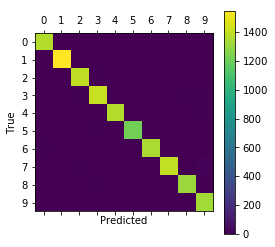

(0.9819285714285715, 0.983, 0.9827142857142858)

In [36]:
print_test_accuracy(mnist_data.test, show_confusion_matrix=True)

Now we save the CNN model which has been trained on MNIST.

In [37]:
saver.save(sess=session, save_path='checkpoints/')

'checkpoints/'

## Labeling function based on output of F1 and F2 and epistemic uncertainty (approximated) on target dataset

"We can model epistemic uncertainty in deep learning models using Monte Carlo dropout sampling at test time.
Dropout sampling can be interpreted as sampling from a distribution over models."

Credits:

- Alex Kendall's presentation: https://alexgkendall.com/media/presentations/oxford_seminar.pdf
- Yarin Gal's paper "Dropout as a Bayesian Approximation Representing Model Uncertainty in Deep Learning" http://proceedings.mlr.press/v48/gal16.pdf
- Kyle Dorman's post "Building a Bayesian Deep Learning Classifier" https://medium.com/towards-data-science/building-a-bayesian-deep-learning-classifier-ece1845bc09

Now test on USPS test set, then run the CNN on the entire training set (we treat the training set as if it is completely unlabeled) and save softmax outputs.

[[209   0   3  24   0  46   1   0  24   8]
 [  0 139   0   1   0   0   0   0 126   0]
 [  0   3 147  16   0   0   0   0   5   0]
 [  0   1   0 178   0   0   0   0   2   0]
 [  0   3   2   0 115   2  10   0  17   7]
 [  0   0   0  35   0 109   0   0   8   1]
 [  1   0   1   0   0   4 121   0  42   0]
 [  0  16  11 109   0   3   1   8  16   5]
 [  0   0   0   4   0   5   1   0 130   0]
 [  0   0   0  46   7   9   0   1  68   8]]


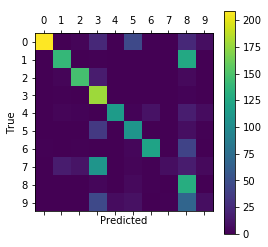

(0.6164604626143088, 0.5911780527165142, 0.6261430876815492)

In [39]:
print_test_accuracy(usps_data.test, show_confusion_matrix=True)

Now we want to bootstrap (also called self-learning) by iteratively pseudo-labeling *target data* based on the assumption, as shown above, that the datasets have enough similarities that the networks trained on source data already can correctly label the majority (>50%) of the target data. We pseudo-label target data IFF:

1. F1's prediction agrees with F2's prediction.
2. Both networks' predictions are quite certain; ie, epistemic uncertainty is low for both.

The shared network (shared_net), F1, and F2 will be trained on source data + the pseudo-labeled target data, while the *F3 will be trained on pseudo-labeled target data alone*.

In [40]:
# T is the number of iterations for sampling. This needs to be run once for every network, to avoid sharing data.
def monte_carlo_preds(dataset_test, T, show_confusion_matrix=True, quieter=False, silent=False, y_pred=None):
    num_test = len(dataset_test.images)
    all_cls_preds = np.zeros(shape=(T, num_test, 10), dtype=np.float64)
    cls_true = dataset_test.cls
    
    if num_test == 0:
        return [], []
    
    for k in range(T):
        i = 0
        cls_preds = np.zeros(shape=(num_test, 10), dtype=np.float64)
        
        while i < num_test:
            j = min(i + test_batch_size, num_test)
            curr_batch_size = j - i

            # Get the images and targets from the test-set between index i and j.
            images = dataset_test.images[i:j, :].reshape(curr_batch_size, img_size_flat)
            labels = dataset_test.labels[i:j, :]
            feed_dict = {x: images, y_true: labels, keep_prob: 0.1}

            # For each T iterations, we want all the softmax outputs from each prediction (N, 10)
            # where N is the input size. all_cls_preds should have shape (T, N, 10).
            cls_preds[i:j] = session.run(y_pred, feed_dict=feed_dict)
            i = j

        all_cls_preds[k] = cls_preds

    # (N, 10)
    prediction_probabilities = np.mean(all_cls_preds, axis=0)

    # (N) one variance for each input.
    prediction_variances = np.apply_along_axis(predictive_entropy, axis=1, arr=prediction_probabilities) 

    return prediction_probabilities, prediction_variances

def predictive_entropy(prediction_probabilities):
    return -1 * np.sum(np.log(prediction_probabilities) * prediction_probabilities, axis=0)

def retrieve_f1f2_predictions(dataset):
    ''' Retrieves the probabilities (not predicted classes) on the given DataSet object; one run only, no dropout. '''
    num_test = len(dataset.images)

    # Allocate an array for the class probabilities which will be calculated in batches and added
    # onto this array; this first element is a dummy to maintain shape as we will add in batches.
    cls_prob_f1 = np.zeros(shape=(1, num_classes), dtype=np.int)
    cls_prob_f2 = np.zeros(shape=(1, num_classes), dtype=np.int)
    i = 0

    while i < num_test:
        j = min(i + test_batch_size, num_test)
        curr_batch_size = j - i
        images = dataset.images[i:j, :].reshape(curr_batch_size, img_size_flat)
        labels = dataset.labels[i:j, :]
        feed_dict = {x: images, y_true: labels, keep_prob: 1.0}

        f1_preds, f2_preds = session.run([f1_y_pred, f2_y_pred], feed_dict=feed_dict)
        cls_prob_f1 = np.concatenate((cls_prob_f1, f1_preds), axis=0)
        cls_prob_f2 = np.concatenate((cls_prob_f2, f2_preds), axis=0)
        
        i = j
    
    cls_prob_f1 = np.delete(cls_prob_f1, 0, 0) # Remove the first dummy element now.
    cls_prob_f2 = np.delete(cls_prob_f2, 0, 0)
    return cls_prob_f1, cls_prob_f2


def select_criteria(mc_selected_f1, mc_selected_f2, target_preds):
    f1_preds = np.argmax(target_preds[0], axis=1)
    f2_preds = np.argmax(target_preds[1], axis=1)
    
    selected = np.zeros((len(f1_preds)))
    count = 0
    
    for i in range(len(f1_preds)):
        if(f1_preds[i] == f2_preds[i] and mc_selected_f1[i] > 0 and mc_selected_f2[i] > 0):
            selected[i] = 1
            count += 1
    print("Number of training images qualifying for pseudo-labeling: " + str(count))
    return selected, count

## Experimenting with epistemic uncertainty using the target test set (labeled).

Remember to reset the CNN model back to the checkpoint before each new experiment, as well as re-designating the dataset. The data object for tri-training includes four different DataSet classes:

    1. data.test - target.test only
    2. data.pseudo - pseudo-labeled target training images
    3. data.train - data.pseudo + source images
    4. data.target - unlabeled target training images

In [41]:
saver.restore(sess=session, save_path='checkpoints/')
data = dataset.generate_combined_dataset(source=mnist_data, target=usps_data)

INFO:tensorflow:Restoring parameters from checkpoints/


In [42]:
preds, uncertainties = monte_carlo_preds( \
                    data.test, 50, show_confusion_matrix=True, quieter=True, y_pred=f3_y_pred)

First we will demonstrate that cases exist where bootstrapping using the softmax threshold would result in mislabelling, whereas the epistemic uncertainty provides a warning that the classifier is uncertain.

Labels: Epistemic uncertainty, softmax prediction, actual class.


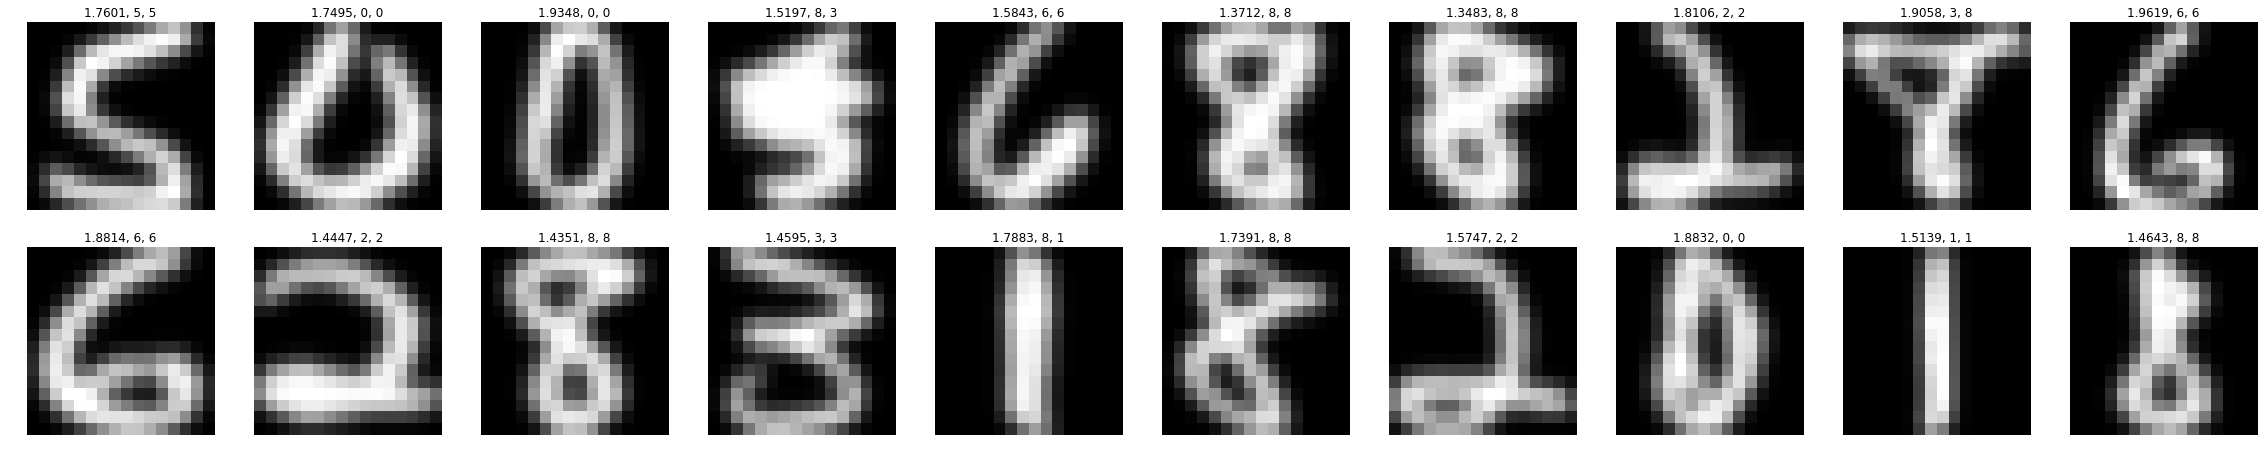

In [43]:
i = 0
to_show = 20

printed_uncertainty = [round(a, 4) for a in uncertainties]
print("Labels: Epistemic uncertainty, softmax prediction, actual class.")

ysb.show_images_with_three_labels_gray(usps_data.test.images[i:(i+to_show)], printed_uncertainty[i:(i+to_show)], \
                                       np.argmax(preds[i:to_show], axis=1), usps_data.test.cls[i:to_show])

Now we want to calculate, using the test round above, what the softmax threshold should be. We will look at the epistemic uncertainty for all the cases where the true class is different from the softmax prediction.

For the USPS test set:
  - 669 cases.
  - Mean uncertainty: 1.82210176081
  - Maximum uncertainty: 2.16107944113
  - Minimum uncertainty: 1.22726302381


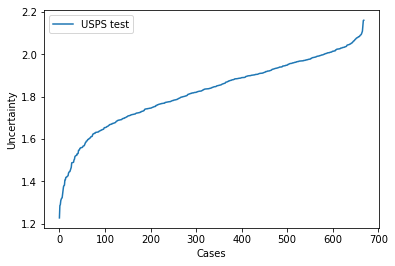

In [44]:
case_epi_unc = []
for i, pred in enumerate(np.argmax(preds, axis=1)):
    if(pred != data.test.cls[i]):
        case_epi_unc.append(uncertainties[i])

print("For the USPS test set:")
print("  - " + str(len(case_epi_unc)) + " cases.")
print("  - Mean uncertainty: " + str(np.mean(case_epi_unc)))
print("  - Maximum uncertainty: " + str(np.max(case_epi_unc)))
print("  - Minimum uncertainty: " + str(np.min(case_epi_unc)))

ysb.plot_with_legend(np.arange(len(case_epi_unc)), [np.sort(case_epi_unc)], ["USPS test"], "Cases", "Uncertainty")

### Experiment 1: Training for a fixed number of boostrap iterations; pseudo-label everything that qualifies without limit.

In [45]:
bootstrap_iterations = 50
monte_carlo_iterations = 50
exp1_acc = []
exp1_adds = []

print("-- Experiment 1 --")

for i in range(bootstrap_iterations):
    # First get predictions for F1 and F2 by running data.target directly through the classifier w/ normal dropout.
    target_preds = retrieve_f1f2_predictions(data.target) # [f1_preds, f2_preds]
    
    # Run Monte Carlo sampling iterations to calculate predictions and epistemic uncertainty for networks F1 and F2.
    mc_preds_f1, unc_f1 = monte_carlo_preds(data.train, monte_carlo_iterations, y_pred=f1_y_pred)
    mc_selected_f1 = np.where(unc_f1 < 1.7, 1, 0)
    
    mc_preds_f2, unc_f2 = monte_carlo_preds(data.train, monte_carlo_iterations, y_pred=f2_y_pred)
    mc_selected_f2 = np.where(unc_f2 < 1.7, 1, 0)
    
    selected, count = select_criteria(mc_selected_f1, mc_selected_f2, target_preds)
    if count > data.target.num_images or count == 0:
        print("Ending iterations early.")
        break
        
    exp1_adds.append(count)
    # It doesn't matter which network's predictions we use since they must have agreed in order to label.
    data.train.add_to_set(selected, data.target, target_preds[0]) 
    data.pseudo.add_to_set(selected, data.target, target_preds[0])
    data.target.remove_from_set(selected)
    
    # Now we optimize F1 and F2 based on the updated training set.
    # F3 is optimized solely based on category loss from the pseudo-labeled targets.
    optimize(data.train, 750, silent=True, dropout_keep_prob=0.85, optimizers=[optimizer_all, optimizer_f1f2])
    optimize(data.pseudo, 750, silent=True, dropout_keep_prob=0.5, optimizers=[optimizer_f3])

    exp1_acc.append(print_test_accuracy(data.test, show_confusion_matrix=False, quieter=True, silent=False))

-- Experiment 1 --
Number of training images qualifying for pseudo-labeling: 5592
Accuracy on test set: F1 60.2%, F2 61.3%, F3 59.7%
Number of training images qualifying for pseudo-labeling: 1355
Accuracy on test set: F1 58.9%, F2 59.1%, F3 61.2%
Number of training images qualifying for pseudo-labeling: 333
Accuracy on test set: F1 60.4%, F2 60.7%, F3 61.0%
Number of training images qualifying for pseudo-labeling: 113
Accuracy on test set: F1 58.4%, F2 59.9%, F3 60.8%
Number of training images qualifying for pseudo-labeling: 25
Accuracy on test set: F1 62.8%, F2 62.2%, F3 61.4%
Number of training images qualifying for pseudo-labeling: 13
Accuracy on test set: F1 59.8%, F2 59.3%, F3 61.2%
Number of training images qualifying for pseudo-labeling: 3
Accuracy on test set: F1 62.6%, F2 63.0%, F3 62.7%
Number of training images qualifying for pseudo-labeling: 1
Accuracy on test set: F1 60.2%, F2 60.6%, F3 60.8%
Number of training images qualifying for pseudo-labeling: 1
Accuracy on test set:

In [46]:
exp1_acc = np.array(np.asarray(exp1_acc).T)
print("Best percent accuracy on target test data: " + str(np.max(exp1_acc[2]))) # F3 accuracy only

Best percent accuracy on target test data: 0.626681011296


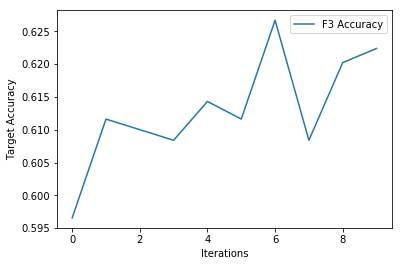

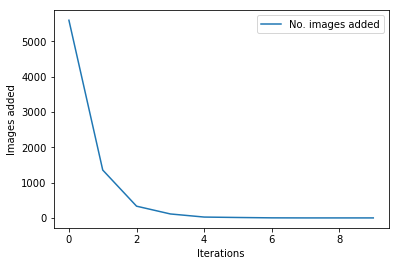

In [47]:
ysb.plot_with_legend(np.arange(len(exp1_acc[2])), [exp1_acc[2]], ["F3 Accuracy"], "Iterations", "Target Accuracy")
ysb.plot_with_legend(np.arange(len(exp1_adds)), [exp1_adds], ["No. images added"], "Iterations", "Images added")

### Experiment 2: resample the pseudo-label candidates at each round to prevent overfitting.

In [51]:
saver.restore(sess=session, save_path='checkpoints/')
# data = dataset.generate_combined_dataset(mnist_data, usps_data)

INFO:tensorflow:Restoring parameters from checkpoints/


In [52]:
bootstrap_iterations = 50
monte_carlo_iterations = 50
exp2_acc = []
exp2_adds = []

print("-- Experiment 2 --")

for i in range(bootstrap_iterations):
    print(str(i) + ": ", end="")
    data = dataset.generate_combined_dataset(mnist_data, usps_data)
    # First get predictions for F1 and F2 by running data.target directly through the classifier w/ normal dropout.
    target_preds = retrieve_f1f2_predictions(data.target) # [f1_preds, f2_preds]
    
    # Run Monte Carlo sampling iterations to calculate predictions and epistemic uncertainty for networks F1 and F2.
    mc_preds_f1, unc_f1 = monte_carlo_preds(data.train, monte_carlo_iterations, y_pred=f1_y_pred)
    mc_selected_f1 = np.where(unc_f1 < 1.7, 1, 0)
    
    mc_preds_f2, unc_f2 = monte_carlo_preds(data.train, monte_carlo_iterations, y_pred=f2_y_pred)
    mc_selected_f2 = np.where(unc_f2 < 1.7, 1, 0)
    
    selected, count = select_criteria(mc_selected_f1, mc_selected_f2, target_preds)
    if count >= data.target.num_images or count == 0:
        print("Ending iterations early.")
        break
        
    exp2_adds.append(count)
    # It doesn't matter which network's predictions we use since they must have agreed in order to label.
    data.train.add_to_set(selected, data.target, target_preds[0]) 
    data.pseudo.add_to_set(selected, data.target, target_preds[0])
    data.target.remove_from_set(selected)
    
    # Now we optimize F1 and F2 based on the updated training set.
    # F3 is optimized solely based on category loss from the pseudo-labeled targets.
    optimize(data.train, 750, silent=True, dropout_keep_prob=0.85, optimizers=[optimizer_all, optimizer_f1f2])
    optimize(data.pseudo, 750, silent=True, dropout_keep_prob=0.5, optimizers=[optimizer_f3])

    exp2_acc.append(print_test_accuracy(data.test, show_confusion_matrix=False, quieter=True, silent=False))

-- Experiment 2 --
Number of training images qualifying for pseudo-labeling: 5599
Accuracy on test set: F1 62.2%, F2 64.1%, F3 62.6%
Number of training images qualifying for pseudo-labeling: 6095
Accuracy on test set: F1 60.9%, F2 62.7%, F3 63.5%
Number of training images qualifying for pseudo-labeling: 6123
Accuracy on test set: F1 63.0%, F2 64.9%, F3 64.5%
Number of training images qualifying for pseudo-labeling: 6158
Accuracy on test set: F1 63.7%, F2 63.9%, F3 64.3%
Number of training images qualifying for pseudo-labeling: 6184
Accuracy on test set: F1 63.1%, F2 64.9%, F3 64.7%
Number of training images qualifying for pseudo-labeling: 6194
Accuracy on test set: F1 63.1%, F2 64.4%, F3 65.9%
Number of training images qualifying for pseudo-labeling: 6268
Accuracy on test set: F1 64.3%, F2 65.5%, F3 62.9%
Number of training images qualifying for pseudo-labeling: 6362
Accuracy on test set: F1 65.6%, F2 64.8%, F3 65.0%
Number of training images qualifying for pseudo-labeling: 6433
Accura

In [53]:
exp2_acc = np.array(np.asarray(exp2_acc).T)
print("Best percent accuracy on target test data: " + str(np.max(exp2_acc[2]))) # F3 accuracy only

Best percent accuracy on target test data: 0.741796664874


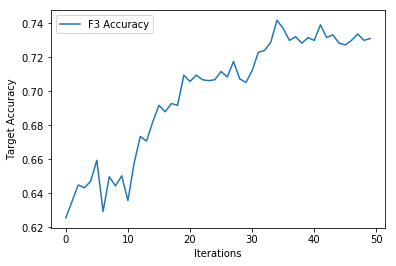

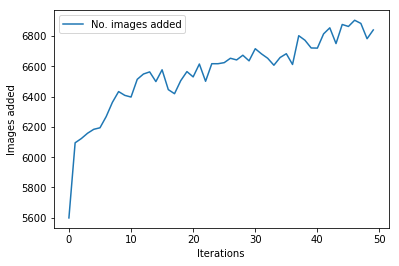

In [54]:
ysb.plot_with_legend(np.arange(len(exp2_acc[2])), [exp2_acc[2]], ["F3 Accuracy"], "Iterations", "Target Accuracy")
ysb.plot_with_legend(np.arange(len(exp2_adds)), [exp2_adds], ["No. images added"], "Iterations", "Images added")

### Experiment 3: resample the pseudo-label candidates at each round to prevent overfitting, but lower the dropout probability (keep more neurons during optimisation).

Trying half as many Monte Carlo iterations to see if runtime can be improved without affecting performance.

In [ ]:
saver.restore(sess=session, save_path='checkpoints/')

In [ ]:
bootstrap_iterations = 50
monte_carlo_iterations = 25
exp3_acc = []
exp3_adds = []

print("-- Experiment 3 --")

for i in range(bootstrap_iterations):
    data = dataset.generate_combined_dataset(mnist_data, usps_data)
    # First get predictions for F1 and F2 by running data.target directly through the classifier w/ normal dropout.
    target_preds = retrieve_f1f2_predictions(data.target) # [f1_preds, f2_preds]
    
    # Run Monte Carlo sampling iterations to calculate predictions and epistemic uncertainty for networks F1 and F2.
    mc_preds_f1, unc_f1 = monte_carlo_preds(data.train, monte_carlo_iterations, y_pred=f1_y_pred)
    mc_selected_f1 = np.where(unc_f1 < 1.7, 1, 0)
    
    mc_preds_f2, unc_f2 = monte_carlo_preds(data.train, monte_carlo_iterations, y_pred=f2_y_pred)
    mc_selected_f2 = np.where(unc_f2 < 1.7, 1, 0)
    
    selected, count = select_criteria(mc_selected_f1, mc_selected_f2, target_preds)
    if count >= data.target.num_images or count == 0:
        print("Ending iterations early.")
        break
        
    exp3_adds.append(count)
    # It doesn't matter which network's predictions we use since they must have agreed in order to label.
    data.train.add_to_set(selected, data.target, target_preds[0]) 
    data.pseudo.add_to_set(selected, data.target, target_preds[0])
    data.target.remove_from_set(selected)
    
    # Now we optimize F1 and F2 based on the updated training set.
    # F3 is optimized solely based on category loss from the pseudo-labeled targets.
    optimize(data.train, 750, silent=True, dropout_keep_prob=0.85, optimizers=[optimizer_all, optimizer_f1f2])
    optimize(data.pseudo, 750, silent=True, dropout_keep_prob=0.85, optimizers=[optimizer_f3])

    exp3_acc.append(print_test_accuracy(data.test, show_confusion_matrix=False, quieter=True, silent=False))

In [ ]:
exp3_acc = np.array(np.asarray(exp3_acc).T)
print("Best percent accuracy on target test data: " + str(np.max(exp3_acc[2]))) # F3 accuracy only

In [ ]:
ysb.plot_with_legend(np.arange(len(exp3_acc[2])), [exp3_acc[2]], ["F3 Accuracy"], "Iterations", "Target Accuracy")
ysb.plot_with_legend(np.arange(len(exp3_adds)), [exp3_adds], ["No. images added"], "Iterations", "Images added")

### Experiment 4: best-performing results from above, but using softmax as confidence predictor instead of epistemic uncertainty.

In [ ]:
saver.restore(sess=session, save_path='checkpoints/')

In [ ]:
bootstrap_iterations = 50
monte_carlo_iterations = 25
exp4_acc = []
exp4_adds = []

threshold = 0.95

print("-- Experiment 4 --")

for i in range(bootstrap_iterations):
    data = dataset.generate_combined_dataset(mnist_data, usps_data)
    # First get predictions for F1 and F2 by running data.target directly through the classifier w/ normal dropout.
    target_preds = retrieve_f1f2_predictions(data.target) # [f1_preds, f2_preds]
    
    # Calculate high-confidence softmax predictions
    f1_selected = cn.split_by_threshold(threshold, target_preds[0], silent=True)
    f2_selected = cn.split_by_threshold(threshold, target_preds[1], silent=True)
    
    selected, count = select_criteria(f1_selected, f2_selected, target_preds)
    
    if count >= data.target.num_images or count == 0:
        print("Ending iterations early.")
        break
        
    exp4_adds.append(count)
    # It doesn't matter which network's predictions we use since they must have agreed in order to label.
    data.train.add_to_set(selected, data.target, target_preds[0]) 
    data.pseudo.add_to_set(selected, data.target, target_preds[0])
    data.target.remove_from_set(selected)
    
    # Now we optimize F1 and F2 based on the updated training set.
    # F3 is optimized solely based on category loss from the pseudo-labeled targets.
    optimize(data.train, 750, silent=True, dropout_keep_prob=0.85, optimizers=[optimizer_all, optimizer_f1f2])
    optimize(data.pseudo, 750, silent=True, dropout_keep_prob=0.85, optimizers=[optimizer_f3])

    exp4_acc.append(print_test_accuracy(data.test, show_confusion_matrix=False, quieter=True, silent=False))

In [ ]:
exp4_acc = np.array(np.asarray(exp4_acc).T)
print("Best percent accuracy on target test data: " + str(np.max(exp4_acc[2]))) # F3 accuracy only

In [ ]:
ysb.plot_with_legend(np.arange(len(exp4_acc[2])), [exp4_acc[2]], ["F3 Accuracy"], "Iterations", "Target Accuracy")
ysb.plot_with_legend(np.arange(len(exp4_adds)), [exp4_adds], ["No. images added"], "Iterations", "Images added")

## Comparison from all experiments.

In [ ]:
x_range = min(len(exp1_acc), len(exp2_acc), len(exp3_acc), len(exp4_acc))

In [ ]:
ysb.plot_with_legend(np.arange(x_range), [exp1_acc[:x_range], exp2_acc[:x_range], exp3_acc[:x_range], exp4_acc[:x_range]], ["Exp 1", "Exp 2", "Exp 3", "Exp 4"], "Iterations", "Accuracy")

In [ ]:
ysb.plot_with_legend(np.arange(x_range), [exp1_adds[:x_range], exp2_adds[:x_range], exp3_acc[:x_range], exp4_acc[:x_range]], ["Exp 1", "Exp 2", "Exp 3", "Exp 4"], "Iterations", "No. images added per iteration")

## Close TensorFlow session

Releases all resources! Run only when prepared to lose saved CNN model.

In [214]:
session.close()